In [29]:
import sklearn

import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('../data/cyberbullying_tweets.csv')

In [14]:
# Both columns have no null values
assert len(df[df.tweet_text.isna()]) == 0
assert len(df[df.cyberbullying_type.isna()]) == 0

In [17]:
# Remove @tags
df.tweet_text = df.tweet_text.apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('@')))

### Possible Feature Extraction
- Check for caps letters (angry messages)
- Isolate cuss words

<AxesSubplot: xlabel='cyberbullying_type', ylabel='count'>

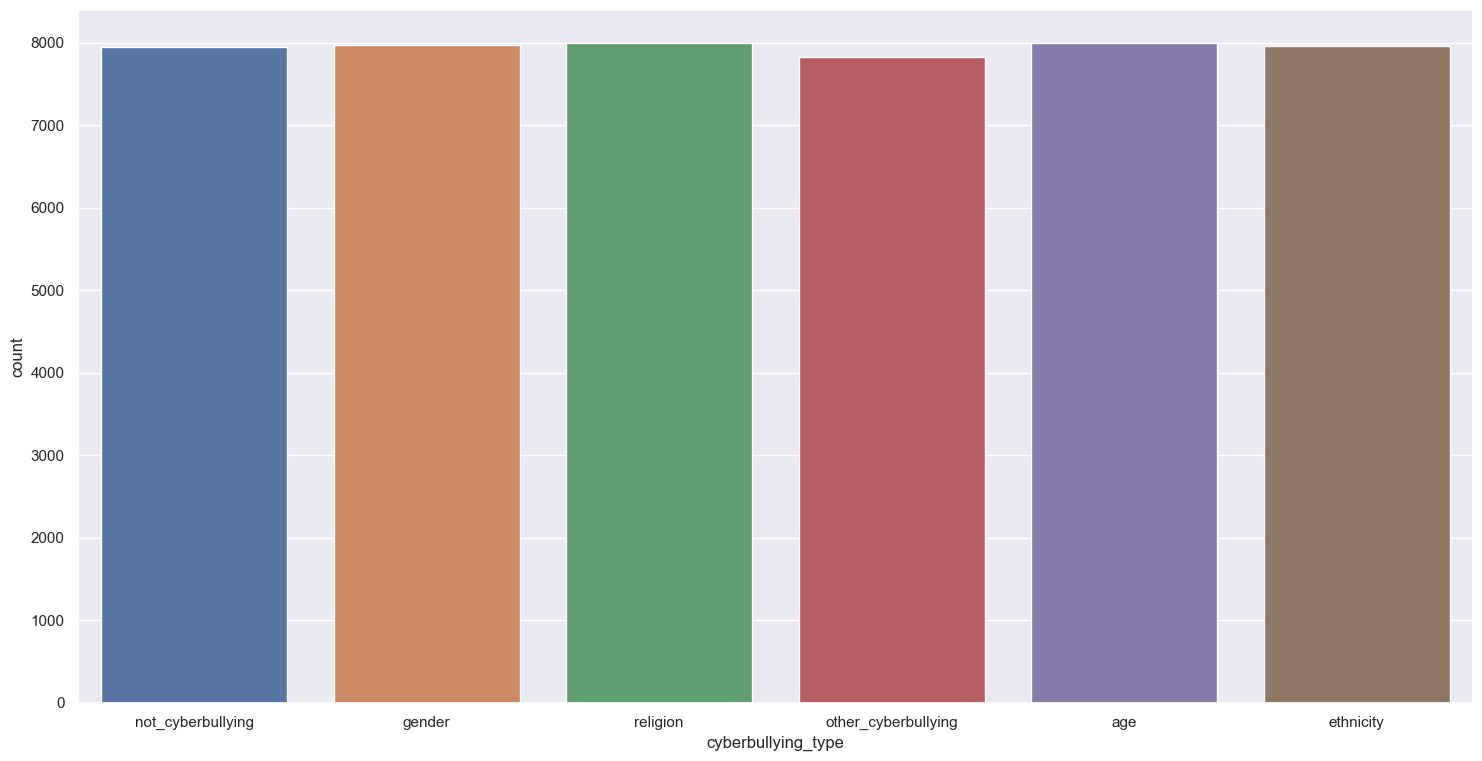

In [31]:
# Target classes are quite balanced, no imbalance resolution techniques required

sns.set(rc={'figure.figsize':(18,9)})
sns.countplot(x=df['cyberbullying_type'])

In [23]:
from sklearn.model_selection import train_test_split
X = df.drop('cyberbullying_type',axis=1)
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True ,random_state=42)

In [66]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38153, 1), (38153,), (9539, 1), (9539,))

In [77]:
X_train.columns

Index(['tweet_text'], dtype='object')

In [152]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


transformer = Pipeline(steps=[('countVectorizer', CountVectorizer()),
                                               ('tfIdfTransformer', TfidfTransformer())])

preprocessor = ColumnTransformer(transformers=[('transformer', transformer, 'tweet_text')
                                              ],remainder='passthrough')


classifier = Pipeline(steps=[('logisticRegressionClassifier', LogisticRegression())])

In [153]:
model = Pipeline(steps=[('preprocessor', preprocessor), 
                        ('classifier', classifier)])

In [154]:
model.fit(X_train, y_train)

/Users/vaibhav/miniconda3/envs/ML/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transformer',
                                                  Pipeline(steps=[('countVectorizer',
                                                                   CountVectorizer()),
                                                                  ('tfIdfTransformer',
                                                                   TfidfTransformer())]),
                                                  'tweet_text')])),
                ('classifier',
                 Pipeline(steps=[('logisticRegressionClassifier',
                                  LogisticRegression())]))])

In [155]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
f1_metric = f1_score(y_test, y_pred, average='weighted')

In [156]:
f1_metric

0.8245143016151575

In [ ]:
# Hyperparameter optimisation

from skopt import BayesSearchCV
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score, average='weighted')

tunable_parameters = {
    'classifier_solver' : ['newton-cg', 'lbfgs', 'liblinear'],
#     'penalty' : ['l2', 'l1', 'elasticnet'],
#     'C' : [100, 10, 1.0, 0.1, 0.01]
}

opt = BayesSearchCV(model, tunable_parameters, n_iter=10, cv=5, scoring=f1_scorer)
opt.fit(X_train, y_train)

In [182]:
# Hyperparameter optimisation

from skopt import BayesSearchCV
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score, average='weighted')

tunable_parameters = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['l2'],
    'C' : [100, 10, 1.0, 0.1, 0.01]
}


classifier = Pipeline(steps=[('logisticRegressionClassifier', 
                              BayesSearchCV(LogisticRegression(max_iter=1000), 
                                            tunable_parameters, 
                                            n_iter=50, 
                                            cv=5, 
                                            scoring=f1_scorer,
                                            n_jobs=5))])


model = Pipeline(steps=[('preprocessor', preprocessor), 
                        ('classifier', classifier)])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
f1_metric = f1_score(y_test, y_pred, average='weighted')
f1_metric